In [3]:
from coinflip.classes import Mappers
from coinflip.modeling import get_dx
from collections import Counter
import datetime
from matplotlib import rc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
import seaborn as sns
from scipy.constants import convert_temperature
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,  ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures, Normalizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.svm import LinearSVR
from time import time
import warnings


def set_fig_size(width=18,height=10):
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(width,height)
    return fig,ax
    

def set_font_size(size=18):
    font = {'family' : 'verdana',
            'size'   : size}
    rc('font', **font)  
    
def make_big(f=18,w=18,h=10):
    set_font_size(size=f)
    fig, ax = set_fig_size(width=w,height=h)
    return fig, ax

def do_little_eda():
    df = get_df()
    make_big()
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    corr = df.corr()
    
    make_big()
    sns.heatmap(corr[['atemp','temp']], annot=True, cmap='coolwarm')
    plt.show()
    
    make_big()
    sns.boxplot(x='atemp', y='temp', data=df)
    plt.xticks(rotation=70)
    
    make_big()
    sns.pairplot(df, hue='season')

#
# Timer magic decorate
#
def timer_func(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

#
# Train/Test data preocessors
#
def get_df(drop_index=False, sort=False):
    df = pd.read_csv('training_data.csv').drop(columns=['Unnamed: 0'])
    if sort:
        df = df.sort_values(by='datetime')
    if drop_index:
        return df.reset_index(drop=True)
    return df


def get_dd(drop_index=True, sort=True):
    df = get_df(drop_index=drop_index, sort=sort).drop(columns=['atemp'])
    return df[list(df.columns[1:])+[df.columns[0]]]


def get_dt(dt):
    return datetime.datetime.fromisoformat(dt)

@timer_func
def get_dx(verbose=False):
    '''
    Reads input file and prepares data for the pipeline.
    '''
    
    def do_verbose(verbose=verbose):
        if verbose:
            print(dx[['datetime','year','hour','month','hr_season','yr_month','yr_season']])
            print()
            print('feature name,','number of disctint values')
            print('set of distinct values')
            print('='*80)
            for time_var in [#'datetime',
                             'season',
                             'year',
                             'hour',
                             'month',
                             'hr_season',
                             'yr_month',
                             'yr_season']:
                print()
                print(time_var,len(list(sorted(list(set(dx[time_var]))))))
                print(list(sorted(list(set(dx[time_var])))))
                    
    low_temp_F, high_temp_F=49,78
    dx = get_dd()
    
    get_datetime   = get_dt
    weekday_mapper = Mappers.weekday_mapper
    season_mapper  = Mappers.season_mapper
    temp_mapper    = Mappers.temp_mapper
    fromisoformat  = datetime.datetime.fromisoformat
    
    dx['tempcat'] = list(map(Mappers.temp_mapper, dx.temp))
    dts = dx['datetime'].copy()
    dx['weekday'] = dts.apply(func=lambda x: weekday_mapper(get_datetime(x).weekday()))
    dx['year'] = dts.apply(func= lambda x: (get_datetime(x).year - 2011)%2011+1)
    dx['month'] = dts.apply(func=lambda x: get_datetime(x).month )
    dx['hour'] = [ get_dt(x).hour for x in dx.datetime ]
    dx['season'] = dx.season.apply(func=lambda x: Mappers.season_mapper(x))
    dx['temp_cat'] = dx.temp.apply(func=lambda x : Mappers.temp_mapper(temp=x,
                                                                       low=convert_temperature(low_temp_F,'f','c'),
                                                                       high=convert_temperature(high_temp_F,'f','c')))
    # 2nd degree interactions
    dx['hr_workingday'] = [ str(dx.iloc[idx].hour) + ','+str(dx.iloc[idx].workingday) for idx in range(len(dx))]
    dx['hr_tempcat'] = [ str(dx.iloc[idx].hour) + ','+str(dx.iloc[idx].tempcat) for idx in range(len(dx))]                                                                         
    dx['hr_season'] = [ str(dx.iloc[idx].hour) + ','+str(dx.iloc[idx].season) for idx in range(len(dx))]
    dx['hr_month'] = [ str(dx.iloc[idx].hour) + ',' + str(dx.iloc[idx].month) for idx in range(len(dx))]
    dx['hr_weekday'] = [ str(dx.iloc[idx].hour) + ',' +str(dx.iloc[idx].weekday) for idx in range(len(dx))]
    dx['yr_month'] = [ str(get_dt(x).year) + ','+str(get_dt(x).month) for x in dx.datetime ]
    dx['yr_season'] = [ str(get_dt(dx.iloc[idx].datetime).year) + ','+str(dx.iloc[idx].season) for idx in range(len(dx)) ]
    dx['season_weekday'] = [ ','.join(x.split(',')[1:]) for x in [ row.yr_season+','+str(row.weekday) for idx, row in dx.iterrows() ] ]
    dx['season_weekday2'] = [ str(row.season)+','+str(row.weekday) for idx, row in dx.iterrows() ]
    assert(all(dx['season_weekday'].values==dx['season_weekday2'].values))
    # 3rd degree interations
    dx['hr_weekday_season'] =  [ str(dx.iloc[idx].hr_weekday)+','+str(dx.iloc[idx].season) for idx in range(len(dx))]
    dx['hr_workingday_season'] = [ str(dx.iloc[idx].hr_workingday)+','+str(dx.iloc[idx].season) for idx in range(len(dx)) ]
    dx['yr_season_weekday']= [ row.yr_season+','+str(row.weekday) for idx, row in dx.iterrows() ]
    dx['season_weekday'] = [ ','.join(x.split(',')[1:]) for x in dx.yr_season_weekday ]
    # masive 4th order vairbale
    dx['yr_season_weekday_hr'] = [ row.yr_season_weekday+','+str(row.hour) for idx,row in dx.iterrows() ]
    return dx.reset_index(drop=True)
    

models = {
    'ridge': RidgeCV,
    # 'elasticnet': ElasticNetCV,
    'lin svm': LinearSVR,
}


@timer_func
def main(pipelines=None,
         dep_var='casual',
         data=None):
    
    dm = pd.FataFrame()
    
    if data is None:
        data = get_dx_new()
    
    y = data[['casual','registered','count']]
    data = data.drop(columns=list(y.columns))
    y = y[dep_var]
    X = pd.get_dummies(data)
    
    if pipelines is None:
        pipelines=dict()

    fig, ax = make_big()
    for modelname in models.keys():
        label = modelname+','+dep_var
        model = models[modelname]()
        pipeline = make_pipeline(MinMaxScaler(), model)
        
        X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
        pipeline.fit(X_train, y_train)
        y_predict = pipeline.predict(X_test)

        maxx = max(max(y_true),max(y_true))
        pipeline.maxx = maxx
        
        pipelines[label] = pipeline
        this_output = {'label': label,
                       'modelname': modelname,
                       'model': model,
                       'dep_var': dep_var,
                       'strmodel': str(model),
                       'coefs': coefs,
                       'mean_absolute_error': float(e1),
                       'mean_absolute_percentage_error': float(e2),
                       'mean_squared_error': float(e3),
                       'mean_squared_log_error': float(e4),
                       'y_true': y_true,
                       'y_pred': y_pred,
                       'error': ''}
        plt.scatter(y_true,y_predict, label=label)

    plt.plot(range(maxx),range(maxx), color='k',linewidth=3, label='y_true=y_pred')
    plt.title(f'Results')
    plt.xlabel('y_true')
    plt.ylabel('y_predict')
    plt.legend()
    plt.show()

    return pipelines

pipes = dict()
for dep_var in ['casual','registred']:
    # pipes['dep_var'] = main()
    print()
    


AttributeError: 'DataFrame' object has no attribute 'yr_season_weekday'

In [11]:
s='''
from copy import deepcopy
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, Normalizer
'''.split('\n')
print('\n'.join(list(sorted(s[1:-1]))))

from copy import deepcopy
from dataclasses import dataclass
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.svm import SVR, LinearSVR
import datetime
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from coinflip.classes import Mappers
from sklearn.preprocessing import LabelBinarizer

LabelBinarizer?
# Mappers.encoders()

In [21]:
pipes['ridge,casual']

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [8]:
# preprocessors
def get_vectorized(data,
                   sparse=False,
                   filter_data=False):
    if filter_data:
        data = data[filter_data]
        
    v = DictVectorizer(sparse=sparse)
    return v, v.fit_transform(data.to_dict('records'))

In [14]:
get_x_train().shape

Processing: training_data.csv kind: train filename: training_data.csv
Function 'get_dx_new' executed in 9.4350s


(8708, 3054)

In [13]:
get_vectorized(dx)[1].shape

(8708, 11772)

In [7]:
X_train, X_test, y_train, y_test = get_train_test_split()

Processing: training_data.csv kind: train filename: training_data.csv
Function 'get_dx_new' executed in 9.4305s
Processing: training_data.csv kind: train filename: training_data.csv
Function 'get_dx_new' executed in 9.4103s
(8708, 3054)
(8708, 3)
Processing: test_data.csv kind: test filename: test_data.csv
Function 'get_dx_new' executed in 9.4648s


ValueError: too many values to unpack (expected 2)

In [5]:
dx = get_dx_new()
dy = dx[['casual','registered','count']]
dd = dx.drop(columns=list(dy.columns))
y = dy['casual']
X = pd.get_dummies(dd)

Function 'get_dx_new' executed in 9.4861s


In [6]:
X.shape

(8708, 11769)

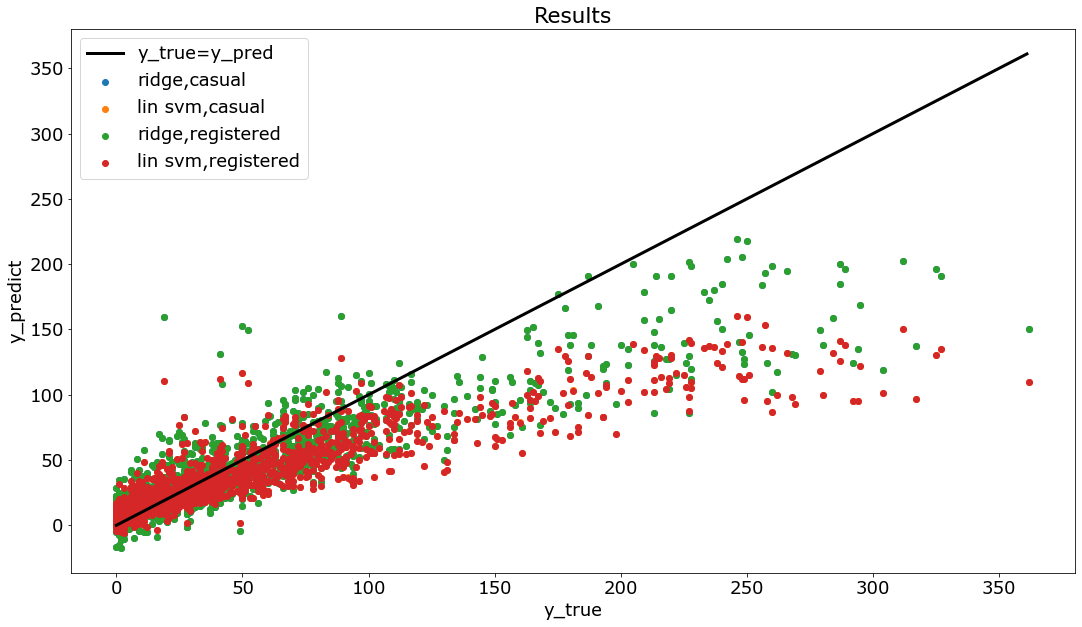

Function 'main' executed in 73.5526s


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import  OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures, Normalizer
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


models = {
    'ridge': RidgeCV,
    # 'elasticnet': ElasticNetCV,
    'lin svm': LinearSVR,
}


@timer_func
def main(pipelines=None):
    
    if pipelines is None:
        pipelines=dict()
    fig, ax = make_big()
    
    for dep_var in ['casual', 'registered']:
        for modelname in models.keys():  
            label = modelname+','+dep_var
            model = models[modelname]()
            pipeline = make_pipeline(MinMaxScaler(), model)
            X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
            pipeline.fit(X_train, y_train)
            y_predict = pipeline.predict(X_test)
            
            maxx = max(max(y_true),max(y_true))
            pipeline.maxx = maxx
            pipelines[label] = pipeline
            plt.scatter(y_true,y_predict, label=label)

    plt.plot(range(maxx),range(maxx), color='k',linewidth=3, label='y_true=y_pred')
    plt.title(f'Results')
    plt.xlabel('y_true')
    plt.ylabel('y_predict')
    plt.legend()
    plt.show()

    return pipelines

    
pipes = main()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

 
class OrdinalEncoderFactory:
    def __init__(self, data):
        self.encoder = OrdinalEncoder()
        self.data = data
        self.transformed_data = self.encoder.fit_transform(self.data)
        self.columns = data.columns
        
class OneHotEncoderFactory:
    def __init__(self, data):
        self.encoder = OneHotEncoder()
        self.data = data
        self.transformed_data = self.encoder.fit_transform(self.data)
        self.columns
        
class PCAFractory(PCA):
    
    def __init__(self, 
                 n_components=3, 
                 data=None,
                 encoder=OrdinalEncoder()):
        super().__init__(n_components=n_components)
        self.data = data
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.encoder = encoder
        self.encoded_data = self.encoder.fit_transform(self.data)
        self.transformed_data = self.pca.fit_transform(self.encoded_data)
        

    def scatter_components(self, comp1=0, comp2=1):
        plt.scatter(transformed_data[:, comp1], transformed_data[:, comp2])
        plt.xlabel(f"Principal Component {comp1}")
        plt.ylabel(f"Principal Component {comp2}")
        plt.show()

    def biplot(self):
        # Create a biplot
        def draw_vector(v0, v1, ax=None):
            ax = ax or plt.gca()
            arrowprops=dict(arrowstyle='->',
                            linewidth=2,
                            shrinkA=0, shrinkB=0)
            ax.annotate('', v1, v0, arrowprops=arrowprops)

        # plot data
        plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.2)
        for length, vector in zip(pca.explained_variance_ratio_, pca.components_):
            v = vector * 3 * np.sqrt(length)
            draw_vector(pca.mean_, pca.mean_ + v)
        plt.axis('equal')
    

# ## from sklearn.decomposition import PCA
# from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


# pca = PCA(n_components=3)
# data = dx[['hour','temp','humidity']].to_numpy()
# transformed_data = pca.fit_transform(data)
# import matplotlib.pyplot as plt

# # Create a scatter plot of the first two principal components
# plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
# plt.xlabel("First Principal Component")
# plt.ylabel("Second Principal Component")
# plt.show() 
        
# oc=OrdinalEncoder()
# data = dx[['hour','hr_weekday', 'hr_weekday_season']]
# cols = data.columns


# transformed_data = oc.fit_transform(dx[['hour','hr_weekday', 'hr_weekday_season']])
# data.to_numpy()



In [ ]:


# class PCAresult(indata):
#     oc = OrdinalEncoder()
#     cols = indata.columns
    


In [700]:
# gen_poly_interaction('hour','weekday')

In [ ]:
# old = get_dx_old()
# new = get_dx_new()

# for col in old.columns:
#     not(col in new.columns) and print(f'Missing column "{col}" in new.columns.')
#     not(all(new[col] == old[col])) and print(f'Column "{col}" has some different values in old, new')
    

In [ ]:
# all(new['hr_tempcat_'] == new['hr_tempcat'])

In [679]:
# old['year'].values[:100]

In [ ]:
# old9,new9 = old.iloc[9],new.iloc[9]
# #

# # new9[list(old.columns)] == old9

# for col in old.columns:
#     print(col,new9[col], old9[col])
    
# dict(new9)

In [ ]:
# for i in range(len(old)):
#     o = int(old.hour.values[i])
#     n = int(new.hour.values[i])
#     o - n and print(i, o, n, o - n)


In [ ]:
# def f(*args):
#     return tuple(args)


# f(1,2,3,99)[-1]

In [ ]:
# class Singleton:
#     _instance = None
#     def __new__(cls):
#         if not cls._instance:
#             cls._instance = super().__new__(cls)
#         return cls._instance
#     @classmethod
#     def get_instance(cls):
#         return cls()


4

In [ ]:
# MyClass.InitCounter